In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import time
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)
print(tf.version.VERSION)

2.15.0


In [ ]:
VOCAB_SIZE = 15000
ATTENTION_DIM = 512
WORD_EMBEDDING_DIM = 128
IMG_HEIGHT = 299
IMG_WIDTH =  299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8,8,1536)

In [ ]:
MAX_CAPTION_LEN = 64

def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(
      inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_'{|}~]?",""
  )

In [ ]:
tokenizer = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = standardize,
    output_sequence_length = MAX_CAPTION_LEN,
)

In [ ]:
tokenizer.load_assets(dir_path = "/content/drive/MyDrive/Colab Notebooks")

In [ ]:
len(tokenizer.get_vocabulary(include_special_tokens = True))

11822

In [ ]:
tokenizer(["<start>This is an Sample Text.<end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[   1,   11,   18, 3700,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
word_to_index = StringLookup(
    mask_token = '',vocabulary = tokenizer.get_vocabulary()
)

index_to_word = StringLookup(
    mask_token = "",vocabulary= tokenizer.get_vocabulary(), invert = True
)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
encoder1 = tf.keras.models.load_model('ENCODE.h5')
deocder1 = tf.keras.models.load_model('DECODE.h5')
decoder_pred = tf.keras.models.load_model('decoder_pred_model.h5')

In [ ]:
MAXIMUM_SENTENCE_LENGTH = 5

def predict_caption1(filename):
  gru_state = tf.zeros((1, ATTENTION_DIM))

  img = tf.image.decode_jpeg(tf.io.read_file(filename), channels = IMG_CHANNELS)
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  img = img / 255

  features = encoder1(tf.expand_dims(img, axis = 0))
  dec_input = tf.expand_dims([word_to_index('<start>')],1)
  result = []
  for i in range(MAX_CAPTION_LEN):
    predictions, gru_state = decoder_pred(
        [dec_input, gru_state, features]
        )
    top_probs, top_idxs = tf.math.top_k(
        input = predictions[0][0], k = 10, sorted = False
    )
    chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
    predicted_id = top_idxs.numpy()[chosen_id][0]

    result.append(tokenizer.get_vocabulary()[predicted_id])

    if predicted_id == word_to_index("<end>"):
      return img, result

    dec_input = tf.expand_dims([predicted_id], 1)
  return img, result

In [ ]:
from google.colab import files
import os
uploaded = files.upload()

Saving 2570945244_3cb4dcaaf8_z.jpg to 2570945244_3cb4dcaaf8_z.jpg


File Exists.....!
a baseball player hitting the ball in the baseball.
a baseball player hitting a baseball with a baseball bat.
a baseball player standing on a baseball diamond.
the baseball player is thrown for a pitch to a pitch during game.
a baseball player standing next to a base.


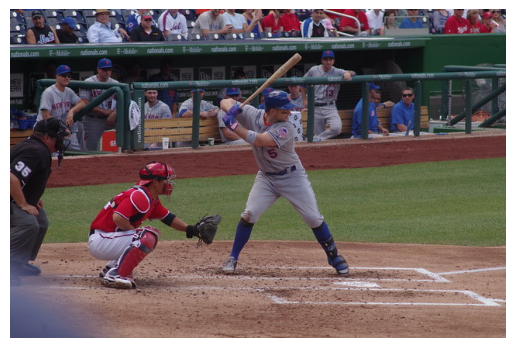

In [ ]:
import os

filename = "/content/drive/MyDrive/Colab Notebooks/imgcap1.jpg"
if not os.path.exists(filename):
    print("The file does not exist at the specified path.")
else:
  print('File Exists.....!')

for i in range(5):
  image, caption = predict_caption1(filename)
  print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels = IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");